In [1]:
# https://adventofcode.com/2021/day/9
from io import StringIO
from collections import deque

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_input(is_sample=True):
    if is_sample:
        lines = "2199943210\n3987894921\n9856789892\n8767896789\n9899965678\n"
    else:
        with open('day09.txt') as f:
            lines = f.read()
    x_width = len(lines.split('\n')[0])
    lines = lines.replace('\n', '')
    x = np.array(list(lines)).astype(int) # 10000 numbers
    x = x.reshape((-1, x_width))
    return x

## part 1

In [3]:
def get_low_points(x):
    x_pad = np.pad(x, (1,1), mode='constant', constant_values=100)
    n_row, n_col = np.shape(x_pad)
    low_points = []
    low_points_xy = []
    for r in range(1, n_row-1):
        for c in range(1, n_col-1):
            center = x_pad[r, c]
            window = [center, x_pad[r-1, c], x_pad[r, c-1], x_pad[r+1, c], x_pad[r, c+1]]
            lowest = np.min(window)
            if lowest == center and np.sum(window==lowest) == 1:
                low_points.append(lowest)
                low_points_xy.append((r-1, c-1))
    return np.array(low_points), np.array(low_points_xy)

In [4]:
x = load_input(is_sample=False)
low_points, _ = get_low_points(x)
risk_level = np.sum(low_points + 1)
print(f"risk level: {risk_level}")

risk level: 524


## part 2

In [5]:
## I thought that highest in the window can be the borderline and wrote this function.
## but it should have been 9 (>_<)
## so this function was not used.  
# def get_basins(x):
#     n_row, n_col = np.shape(x)
#     x_pad = np.pad(x, (1,1), mode='constant', constant_values=-1)
#     y = x_pad.copy()
#     n_row, n_col = np.shape(x_pad)
#     low_points = []
#     for r in range(1, n_row-1):
#         for c in range(1, n_col-1):
#             center = x_pad[r, c]
#             window = [center, x_pad[r-1, c], x_pad[r, c-1], x_pad[r+1, c], x_pad[r, c+1]]
#             highest = np.max(window)
#             if highest == center:
#                 y[r, c] = 1
#             else:
#                 y[r, c] = 0
#     return y[1:-1, 1:-1]

In [94]:
#window = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]
window = [[1, 0], [0, 1], [-1, 0], [0, -1]]

def is_ok(x, i, j, processed):
    n_row, n_col = np.shape(x)
    return ((i < n_row) and (i >= 0) \
            and (j < n_col) and (j >= 0) \
            and (x[i, j] != 9) and (processed[i, j] == 0))


def check_movable_region(x, i, j, window, y, processed):
    processed[i, j] = 1
    for r, c in window:
        if is_ok(x, i+r, j+c, processed) and (x[i+r, j+c] >= x[i, j]):
            processed[i+r, j+c] = 1
            y[i+r, j+c] = 10
    return y, processed

            
def subtract_array(q1, q2):
    # index to removed.
    assert len(q1)>=len(q2), "should be len(q1) >= len(q2)."
    rs = []
    for q2_ in q2:
        for r, q1_ in enumerate(q1):
            if (q1_ == q2_).all():
                rs.append(r)
    return np.delete(q1, rs, axis=0)


def get_queue(y, processed_center, is_first=False):
    i_x, i_y = np.where(y==10)
    q = np.vstack((i_x, i_y)).T
    if not is_first:
        q = subtract_array(q, np.array(processed_center))
    return q


# def extract_basin(basins, i, j):
#     '''exctract one basin from basins, which can be obtained by get_basins() '''
#     x = basins.copy()
    
#     # region marker, same size as x.
#     y = x.copy()
#     # matrix to check if each point is processed, same size as x.
#     processed = np.zeros(np.shape(x)).astype(int)

#     # starting point.
#     y[i, j] = 2
#     processed[i, j] = 1
#     processed_center = []
#     check_movable_region(x, i, j, window, y, processed)
#     q = get_queue(y, processed_center, is_first=True)
    
#     while len(q) > 0:
#         #print('\r' + f"{np.sum(np.array(processed_center)==1)}, {len()}", end="")
#         i, j = q[0]
#         processed_center.append((i, j))

#         # set 2 into the points belong to the region.
#         for i_x, i_y in zip(*np.where(y==2)):
#             check_movable_region(x, i_x, i_y, window, y, processed)

#         # update the queue.
#         q = get_queue(y, processed_center)
#     return np.where(y==2, 1, 0)


def get_basin(x, i, j, window):
    # region marker, same size as x.
    y = x.copy()

    # matrix to check if each point is processed, same size as x.
    processed = np.zeros(np.shape(x)).astype(int)
    processed_center = []

    # starting point.
    y[i, j] = 10
    processed_center.append((i, j))
    y, processed = check_movable_region(x, i, j, window, y, processed)
    q = get_queue(y, processed_center)

    while len(q) > 0:
        i, j = q[0]
        processed_center.append((i, j))
        y, processed = check_movable_region(x, i, j, window, y, processed)
        q = get_queue(y, processed_center)

    return np.where(y==10, 1, 0)
    
    
def disp_heatmap(x):
    plt.imshow(x, cmap='hot', interpolation='nearest')
    plt.show()

In [111]:
import time
x = load_input(is_sample=False)

time0 = time.time()
_, low_points = get_low_points(x)

basin_sizes = []
for low_point in low_points:
    i, j = low_point
    basin = get_basin(x, i, j, window)
    #disp_heatmap(basin)
    basin_sizes.append(np.sum(basin))
time.time() - time0

28.582788944244385

In [110]:
# answer
basin_sizes = np.array(basin_sizes)
biggest3 = basin_sizes[basin_sizes.argsort()[-3:]]
print(f"product of the 3 largest basins: {np.prod(biggest3)}")

product of the 3 largest basins: 1134


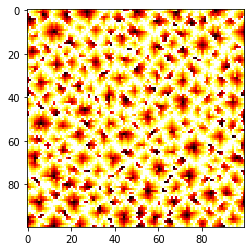

In [108]:
import time
x = load_input(is_sample=False)

#disp_heatmap(get_basins(x))
disp_heatmap(x)
